# `Contingent` Tutorial

In [1]:
import numpy as np
from rich import print
from contingency import Contingent
import matplotlib.pyplot as plt

np.set_printoptions(formatter={'float_kind':"{:.5g}".format})

In [2]:
y_true = np.array([0,1,0,0,1]).astype(bool)
y_pred = np.array([0,1,0,1,0]).astype(bool)

## Basic Instantiation

In [3]:
M = Contingent(y_pred = y_pred, y_true=y_true)
    
# M.precision
print(M)

Contingent(
    y_true=array([[False,  True, False, False,  True]]),
    y_pred=array([[False,  True, False,  True, False]]),
    weights=None,
    TP=array([1]),
    FP=array([1]),
    FN=array([1]),
    TN=array([2]),
    PP=array([2]),
    PN=array([3]),
    P=array([2]),
    N=array([3]),
    PPV=masked_array(data=[0.5],
             mask=[False],
       fill_value=1e+20),
    NPV=masked_array(data=[0.6666666666666666],
             mask=[False],
       fill_value=1e+20),
    TPR=masked_array(data=[0.5],
             mask=[False],
       fill_value=1e+20),
    TNR=masked_array(data=[0.6666666666666666],
             mask=[False],
       fill_value=1e+20)
)

We now have access to properties that will return useful metrics from these contingency counts, such as 

- [Matthew's Correlation Coefficient](https://en.wikipedia.org/wiki/Phi_coefficient) (MCC)
- [F1/F2](https://en.wikipedia.org/wiki/F-score) scores
- [Fowlkes-Mallows](https://en.wikipedia.org/wiki/Fowlkes%E2%80%93Mallows_index) (G) index
- Many more...

In [4]:
print(M.mcc, M.F, M.G, sep='\n')
# m = np.vstack([M.TPR,M.TNR,M.PPV,M.NPV]).T#.filled(0)
# l = np.sqrt(m).prod(axis=0)
# r = np.sqrt(1-m).prod(axis=0)
# M_batch.TPR
# np.sqrt(m)#.prod(axis=1)
# (l-r).filled(0)


[0.16667]
[0.5]
[0.5]

## Contingencies from Probabilities

Most ML systems do not output binary classifications directly, but instead output probabilities or weights. 
Thresholding these will create an entire "family" of predictions, as the threshold increases or lowers. 

`Contingent` easily handles this as a simple broadcasting operation, using the `from_scalar()` constructor: 

In [5]:
y_prob = np.array([0.1,0.8,0.1,.7,.25])

In [6]:
M_batch = Contingent.from_scalar(y_true, y_prob)
print(M_batch.weights, M_batch.y_pred, sep='\n')

[0 1e-05 0.21429 0.85714 0.99999 1]
[[ True  True  True  True  True]
 [ True  True  True  True  True]
 [False  True False  True  True]
 [False  True False  True False]
 [False  True False False False]
 [False False False False False]]

Note how the number of positives decreases as the threshold increases. 

Likewise, we can see the set of metrics is now vectorized as well: 

In [7]:
print(M_batch.mcc, M_batch.F, M_batch.G, sep='\n')

[0 0 0.66667 0.16667 0.61237 0]
[0.57143 0.57143 0.8 0.5 0.66667 0]
[0.63246 0.63246 0.8165 0.5 0.70711 0]

## Expected Values

We would like a single score that summarizes our classifier's performance accross _all_ thresholds. 

This can traditionally be done using Average Precision Score (APS), which is the average precision weighted across the _recall_ scores. 
Alternatively, `Contingent.expected` also can calculate the expected value of each provided score type, across the set of unique threshold values. 

In [8]:
for score in ('aps', 'mcc', 'F'):
    print(M_batch.expected(score))

0.8333333333333333

0.39492652768935094

0.6481253367346939

## Optional Plotting Utilities

There is an included plot utility for making nicely formatted P-R curve axes to plot your `Contingent` metrics on. 
While this does not automatically plot the P-R curves themselves, this functionality will be added at a later time. 

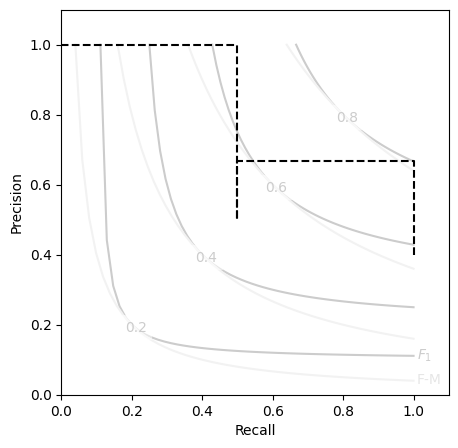

In [9]:
from contingency.plots import PR_contour

M_batch.expected('aps')
plt.figure(figsize=(5,5))
PR_contour()
plt.step(M_batch.recall, M_batch.precision, color='k', ls='--', where='post')
# plt.plot(M_batch.recall, M_batch.precision, color='k', ls='--')

## Performance

In [10]:
rng = np.random.default_rng(24) ## mph, the avg cruising airspeed velocity of an unladen (european) swallow
y_src = rng.random(10000)
y_true = y_src>0.7

In [11]:
y_pred = y_src + 0.05*rng.normal(size=10000)
y_pred
# rng.normal(

plt.plot(Contingent.from_scalar(y_true, y_pred, subsample_factor=100).mcc)

TypeCheckError: Type-check error whilst checking the parameters of contingency.contingent.Contingent.__init__.
The problem arose whilst typechecking parameter 'y_pred'.
Actual value: bool[10002,100](numpy)
Expected type: <class 'Bool[ndarray, '*#batch feat']'>.
----------------------
Called with parameters: {
  'self': Contingent(...),
  'y_true': bool[10000](numpy),
  'y_pred': bool[10002,100](numpy),
  'weights': f64[10002](numpy)
}
Parameter annotations: (self, y_true: Bool[ndarray, 'feat'] = Ellipsis, y_pred: Bool[ndarray, '*#batch feat'] = Ellipsis, weights: Optional[Num[ndarray, '*#batch']] = None) -> Any.
The current values for each jaxtyping axis annotation are as follows.
feat=10000

In [17]:
%timeit Contingent.from_scalar(y_true, y_pred).expected('aps')
%timeit Contingent.from_scalar(y_true, y_pred).expected('mcc')

2.96 ms ± 94.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.44 ms ± 133 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


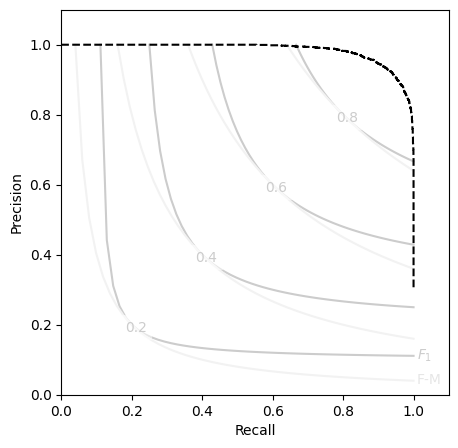

In [35]:
M_big = Contingent.from_scalar(y_true, y_pred)
# M_batch.expected('aps')
plt.figure(figsize=(5,5))
PR_contour()
plt.step(M_big.recall, M_big.precision, color='k', ls='--', where='post')

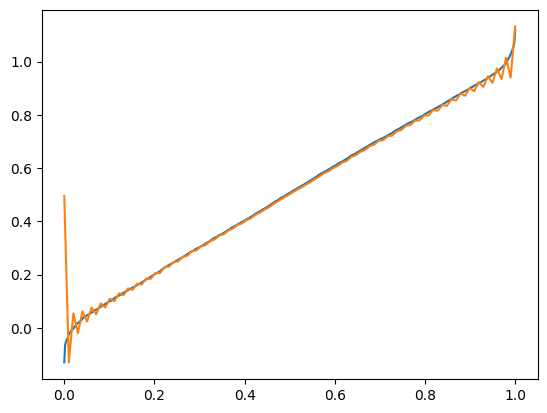

In [40]:
from scipy.signal import resample

plt.plot(np.linspace(0,1,np.unique(y_pred).shape[0]), np.unique(y_pred))
plt.plot(np.linspace(0,1,100),resample(np.unique(y_pred), 100) )

# y_prob

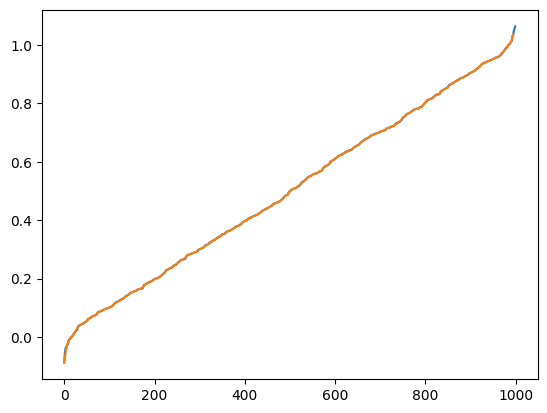

In [46]:
x = np.unique(y_pred)
x_subs = np.interp(np.arange(0,x.shape[0],5), np.arange(0,x.shape[0]), x)

plt.plot(np.arange(0,x.shape[0]), x)
plt.plot(np.arange(0,x.shape[0],5), x_subs)